# Example for xarray and xcube

**Author(s):** Konstantin Ntokas  
**Affiliation:** [Brockmann Consult](https://www.brockmann-consult.de/)    
**Contact:** konstantin.ntokas@brockmann-consult.de  

---



## Introduction

This notebook demonstrates the features of the **xarray EOPF backend** and the **xcube EOPF data store**. 

<div style="border: 2.5px solid #999; padding: 1em; border-radius: 6px; background-color: #eaeaea; margin-bottom: 1em;">
  <strong>Questions:</strong>
  <ul>
    <li>How can EOPF Zarr samples be opened in an analysis-ready data model?</li>
    <li>How can 3D data cubes be generated from EOPF Zarr samples?</li>
  </ul>
</div>

<div style="border: 2.5px solid #999; padding: 1em; border-radius: 6px; background-color: #eaeaea;">
  <strong>Objectives:</strong>
  <ul>
    <li>Understand the key features of the xarray EOPF backend, including its analysis-ready mode.</li>
    <li>Learn how to use the xcube EOPF data store to open multiple Sentinel EOPF Zarr samples and combine them into a 3D data cube.</li>
  </ul>
</div>


> **Disclaimer**  
> This notebook demonstrates the use of open source software and is intended for educational and illustrative purposes only. All software used is subject to its respective licenses. The authors and contributors of this notebook make no guarantees about the accuracy, reliability, or suitability of the content or included code. Use at your own discretion and risk. No warranties are provided, either express or implied.
---

## Table of Contents

<ul style="list-style-type:none; padding-left: 0;">
  <li>🔹 <a href="#Setup"><strong>Setup</strong></a></li>
  <li>🔹 <a href="#xarray-EOPF-backend:-Open-one-Sample"><strong>xarray EOPF backend: Open one Sample</strong></a> </li>
  <li>🔹 <a href="#xcube-EOPF-data-store:-Open-multiple-Sample"><strong>xcube EOPF data store: Open multiple Sample</strong></a> </li>
  <li>🔹 <a href="#Conclusion"><strong>Conclusion</strong></a></li>
</ul>

<hr>


## Setup

The **xarray EOPF backend** and **xcube EOPF backend** are implemented as an **xarray plugin** and **xcube plugin**, respectively. Both can be installed using either `pip` or `conda/mamba` from the conda-forge channel.

- 📦 **PyPI:** `pip install xarray-eopf` and `pip install xcube-eopf`
- 🐍 **Conda (conda-forge):** `conda install -c conda-forge xarray-eopf` and `conda install -c conda-forge xcube-eopf` 

You can also use **Mamba** as a faster alternative to Conda: `mamba install -c conda-forge xarray-eopf`

In [1]:
import os

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
from xcube.core.store import new_data_store
from xcube.webapi.viewer import Viewer
from xcube_eopf.utils import reproject_bbox

---

## xarray EOPF backend: Open one Sample

The xarray-eopf backend for EOPF data products can be selecterd by setting `engine="eopf-zarr"` in `xarray.open_dataset(..)` and `xarray.open_datatree(..)` method. It supports two modes of operation:

- **Analysis Mode** *(default)*
- **Native Mode**

### Native mode

- We can use the [EOPF Zarr Samples STAC API](`https://stac.core.eopf.eodc.eu`) to search for tiles by bounding box and time range.
- The `"product"` asset can be used to open an EOPF Zarr product.
- Additional fields in the asset provide the parameters required to open the dataset.

In [2]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=[7.2, 44.5, 7.4, 44.7],
        datetime=["2025-04-30", "2025-05-01"],
    ).items()
)
items

[<Item id=S2B_MSIL2A_20250430T101559_N0511_R065_T32TLQ_20250430T131328>]

We can now use the `href` and `xarray:open_datatree_kwargs` from the item to open the product.

In [3]:
item = items[0]
href = item.assets["product"].href
open_params = item.assets["product"].extra_fields["xarray:open_datatree_kwargs"]
open_params

{'chunks': {}, 'engine': 'eopf-zarr', 'op_mode': 'native'}

In [4]:
dt = xr.open_datatree(href, **open_params)
dt

<xarray.DataTree>
Group: /
│   Attributes: (2)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 4)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 32B 1 2 3 4
│   │         * x                              (x) int64 184B 300000 305000 ... 410000
│   │         * y                              (y) int64 184B 5000040 4995040 ... 4890040
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 440kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 10980, x: 10980)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
│   │   │   │         * y        (y) int64 88kB 5000035 5000025 5000015 ... 4890265 4890255 4890245
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 5490, x: 5490)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 44kB 300010 300030 300050 300070 ... 409750 409770 409790
│   │   │   │         * y        (y) int64 44kB 5000030 5000010 4999990 ... 4890290 4890270 4890250
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 1830, x: 1830)
│   │   │           Coordinates:
│   │   │             * x        (x) int64 15kB 300030 300090 300150 300210 ... 409650 409710 409770
│   │   │             * y        (y) int64 15kB 5000010 4999950 4999890 ... 4890390 4890330 4890270
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 3MB dask.array<chunksize=(305, 305), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 3MB dask.array<chunksize=(305, 305), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 3MB dask.array<chunksize=(305, 305), meta=np.ndarray>
│   │   ├── Group: /conditions/mask/l1c_classification
│   │   │   └── Group: /conditions/mask/l1c_classification/r60m
│   │   │           Dimensions:  (y: 1830, x: 1830)
│   │   │           Coordina

As an example, we plot the quicklook image to view the RGB image. 

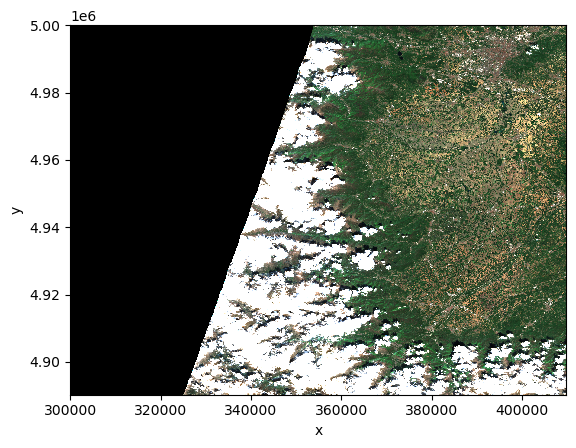

/home/konstantin/micromamba/envs/xcube-eopf/lib/python3.13/site-packages/xcube_resampling/coarsen.py:103: RuntimeWarning: Mean of empty slice
  return nan_reducer(block, axis)


In [5]:
dt.quality.l2a_quicklook.r60m.tci.plot.imshow(rgb="band")

The same applies to the `xr.open_dataset` method, which returns a flattened DataTree represented as an `xr.Dataset`.

> Note, this mode can be usefull to support compatibility with existing workflows that rely on the traditional `xr.Dataset` model, since the `xarray.DataTree` data model is relatively new, introduced in [xarray v2024.10.0](https://docs.xarray.dev/en/v2024.10.0/whats-new.html) (October 2024). 

In [6]:
ds = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"]
)
ds

<xarray.Dataset> Size: 9GB
Dimensions:                                            (
                                                        conditions_geometry_angle: 2,
                                                        conditions_geometry_band: 13,
                                                        conditions_geometry_y: 23,
                                                        conditions_geometry_x: 23,
                                                        conditions_geometry_detector: 4,
                                                        ...
                                                        quality_mask_r20m_y: 5490,
                                                        quality_mask_r20m_x: 5490,
                                                        quality_mask_r60m_y: 1830,
                                                        quality_mask_r60m_x: 1830,
                                                        quality_probability_y: 5490,
                                                        quality_probability_x: 5490)
Coordinates: (12/63)
  * conditions_geometry_angle                          (conditions_geometry_angle) <U7 56B ...
  * conditions_geometry_band                           (conditions_geometry_band) <U3 156B ...
  * conditions_geometry_detector                       (conditions_geometry_detector) int64 32B ...
  * conditions_geometry_x                              (conditions_geometry_x) int64 184B ...
  * conditions_geometry_y                              (conditions_geometry_y) int64 184B ...
  * conditions_mask_detector_footprint_r10m_x          (conditions_mask_detector_footprint_r10m_x) int64 88kB ...
    ...                                                 ...
  * quality_mask_r20m_y                                (quality_mask_r20m_y) int64 44kB ...
  * quality_mask_r60m_x                                (quality_mask_r60m_x) int64 15kB ...
  * quality_mask_r60m_y                                (quality_mask_r60m_y) int64 15kB ...
    quality_probability_band                           int64 8B ...
  * quality_probability_x                              (quality_probability_x) int64 44kB ...
  * quality_probability_y                              (quality_probability_y) int64 44kB ...
Data variables: (12/86)
    conditions_geometry_mean_sun_angles                (conditions_geometry_angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    conditions_geometry_mean_viewing_incidence_angles  (conditions_geometry_band, conditions_geometry_angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
    conditions_geometry_sun_angles                     (conditions_geometry_angle, conditions_geometry_y, conditions_geometry_x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
    conditions_geometry_viewing_incidence_angles       (conditions_geometry_band, conditions_geometry_detector, conditions_geometry_angle, conditions_geometry_y, conditions_geometry_x) float64 440kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
    conditions_mask_detector_footprint_r10m_b02        (conditions_mask_detector_footprint_r10m_y, conditions_mask_detector_footprint_r10m_x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    conditions_mask_detector_footprint_r10m_b03        (conditions_mask_detector_footprint_r10m_y, conditions_mask_detector_footprint_r10m_x) uint8 121MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    ...                                                 ...
    quality_mask_r20m_b8a                              (quality_mask_r20m_y, quality_mask_r20m_x) uint8 30MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    quality_mask_r60m_b01                              (quality_mask_r60m_y, quality_mask_r60m_x) uint8 3MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    quality_mask_r60m_b09                              (quality_mask_r60m_y, quality_mask_r60m_x) uint8 3MB dask.array<chunksize=(305, 305), meta=np.ndar

We can also filter the output variables indicated as string, an iterable of names, or a regular expression (regex) pattern, as shown below.

In [7]:
ds = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
    variables="measurements*"
)
ds

<xarray.Dataset> Size: 7GB
Dimensions:                (measurements_r10m_y: 10980,
                            measurements_r10m_x: 10980,
                            measurements_r20m_y: 5490,
                            measurements_r20m_x: 5490,
                            measurements_r60m_y: 1830, measurements_r60m_x: 1830)
Coordinates:
  * measurements_r10m_x    (measurements_r10m_x) int64 88kB 300005 ... 409795
  * measurements_r10m_y    (measurements_r10m_y) int64 88kB 5000035 ... 4890245
  * measurements_r20m_x    (measurements_r20m_x) int64 44kB 300010 ... 409790
  * measurements_r20m_y    (measurements_r20m_y) int64 44kB 5000030 ... 4890250
  * measurements_r60m_x    (measurements_r60m_x) int64 15kB 300030 ... 409770
  * measurements_r60m_y    (measurements_r60m_y) int64 15kB 5000010 ... 4890270
Data variables: (12/25)
    measurements_r10m_b02  (measurements_r10m_y, measurements_r10m_x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    measurements_r10m_b03  (measurements_r10m_y, measurements_r10m_x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    measurements_r10m_b04  (measurements_r10m_y, measurements_r10m_x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    measurements_r10m_b08  (measurements_r10m_y, measurements_r10m_x) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    measurements_r20m_b01  (measurements_r20m_y, measurements_r20m_x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    measurements_r20m_b02  (measurements_r20m_y, measurements_r20m_x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    ...                     ...
    measurements_r60m_b06  (measurements_r60m_y, measurements_r60m_x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    measurements_r60m_b07  (measurements_r60m_y, measurements_r60m_x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    measurements_r60m_b09  (measurements_r60m_y, measurements_r60m_x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    measurements_r60m_b11  (measurements_r60m_y, measurements_r60m_x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    measurements_r60m_b12  (measurements_r60m_y, measurements_r60m_x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    measurements_r60m_b8a  (measurements_r60m_y, measurements_r60m_x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
Attributes: (2)

## Analysis Mode

The analysis mode provides an **analysis-ready, resampled view** of the data, currently available for **Sentinel-2** and **Sentinel-3**.

**In-depth examples:**  
- [Sentinel-2](https://eopf-sample-service.github.io/eopf-sample-notebooks/introduction-xarray-eopf-plugin/)  
- [Sentinel-3](add link)  

In [8]:
ds = xr.open_dataset(
    href, engine="eopf-zarr", chunks={}, op_mode="analysis", resolution=60
)
ds

<xarray.Dataset> Size: 332MB
Dimensions:      (y: 1830, x: 1830)
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) int64 15kB 300030 300090 300150 ... 409650 409710 409770
  * y            (y) int64 15kB 5000010 4999950 4999890 ... 4890330 4890270
    band         int64 8B ...
Data variables: (12/15)
    b08          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    cld          (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    snw          (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b01          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b02          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b03          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    ...           ...
    b07          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b09          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b11          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b12          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b8a          (y, x) float64 27MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    scl          (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
Attributes: (34)

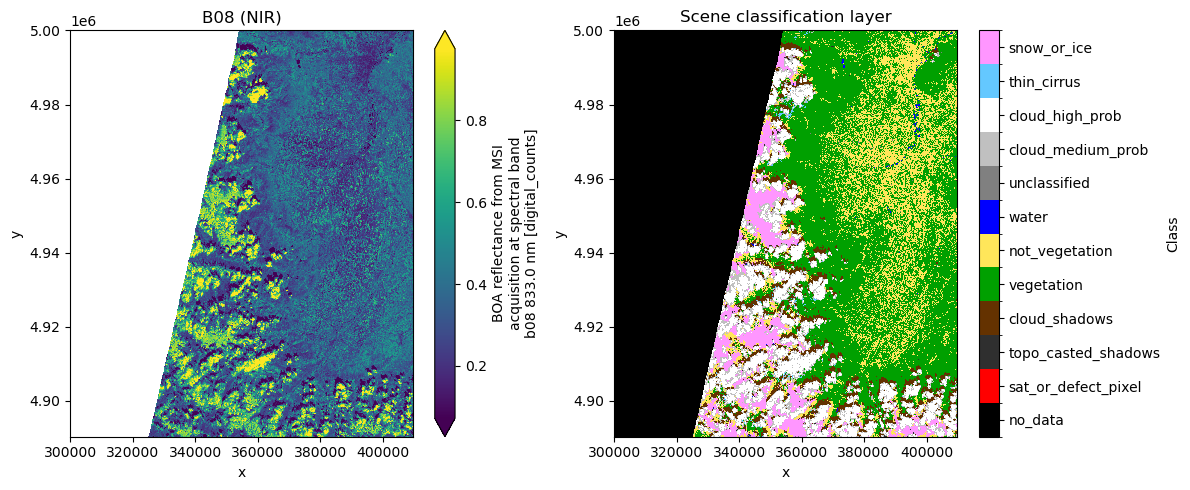

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ds.b08.plot(ax=ax[0], robust=True)
ax[0].set_title("B08 (NIR)")

cmap = mcolors.ListedColormap(ds.scl.attrs["flag_colors"].split(" "))
nb_colors = len(ds.scl.attrs["flag_values"])
norm = mcolors.BoundaryNorm(
    boundaries=np.arange(nb_colors + 1) - 0.5, ncolors=nb_colors
)
im = ds.scl.plot.imshow(ax=ax[1], cmap=cmap, norm=norm, add_colorbar=False)
cbar = fig.colorbar(im, ax=ax[1], ticks=ds.scl.attrs["flag_values"])
cbar.ax.set_yticklabels(ds.scl.attrs["flag_meanings"].split(" "))
cbar.set_label("Class")
ax[1].set_title("Scene classification layer")

plt.tight_layout()

---

## xcube EOPF data store: Open multiple Sample

This plugin allows to generate 3D spatiotemporal datacubes from multiple EOPF Zarr Samples. The workflow for building these data cubes involves the following steps:

1. **Query** products using the [EOPF STAC API](https://stac.browser.user.eopf.eodc.eu/) for a given time range and 
   spatial extent.
2. **Retrieve** observations as cloud-optimized Zarr chunks via the 
   [xarray-eopf backend](https://eopf-sample-service.github.io/xarray-eopf/).
3. **Mosaic** spatial tiles into single images per timestamp.
4. **Stack** the mosaicked scenes along the temporal axis to form a 3D cube.

The workflow is integrated into the `open_data` method, with is shown below. First we need to create data store instance.

In [10]:
store = new_data_store("eopf-zarr")

In [11]:
bbox = [9.85, 53.5, 10.05, 53.6]
crs_utm = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)

💡 **Note**  
`open_data()` builds a Dask graph and returns a lazy `xarray.Dataset`. No actual data is loaded at this point. 

In [12]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10,
    crs=crs_utm,
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 953 ms, sys: 25.3 ms, total: 978 ms
Wall time: 8.15 s


<xarray.Dataset> Size: 114MB
Dimensions:      (time: 3, y: 1132, x: 1341)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B ...
  * x            (x) float64 11kB 5.562e+05 5.563e+05 ... 5.696e+05 5.696e+05
  * y            (y) float64 9kB 5.94e+06 5.94e+06 ... 5.928e+06 5.928e+06
Data variables:
    b02          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    b03          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    b04          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    scl          (time, y, x) uint8 5MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
Attributes: (4)

We can plot the the red band (`b04`) for the first time step as an example. This operation triggers data downloads and processing.

CPU times: user 409 ms, sys: 47 ms, total: 456 ms
Wall time: 1.01 s


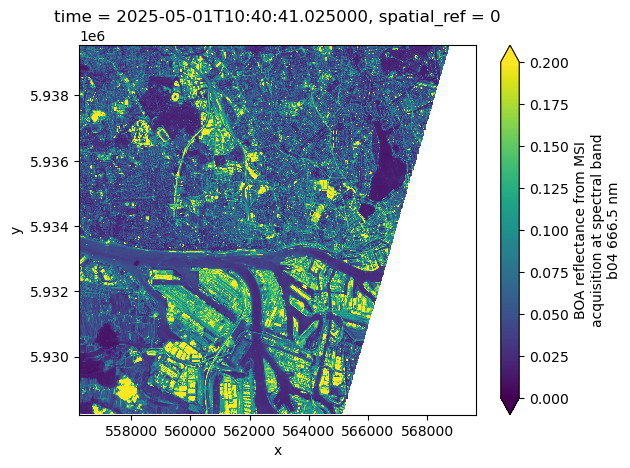

In [13]:
%%time
ds.b04.isel(time=0).plot(vmin=0, vmax=0.2)

Now we can request the same data cube but in geographic projection ("EPSG:4326"). xcube-eopf can reproject the datacube to any projection requested by the user.

In [14]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10 / 111320,  # meters converted to degrees (approx.)
    crs="EPSG:4326",
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 860 ms, sys: 17.2 ms, total: 878 ms
Wall time: 9.4 s


<xarray.Dataset> Size: 186MB
Dimensions:      (time: 3, lon: 2228, lat: 1115)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 18kB 9.85 9.85 9.85 9.85 ... 10.05 10.05 10.05
  * lat          (lat) float64 9kB 53.6 53.6 53.6 53.6 ... 53.5 53.5 53.5 53.5
Data variables:
    b02          (time, lat, lon) float64 60MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
    b03          (time, lat, lon) float64 60MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
    b04          (time, lat, lon) float64 60MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
    scl          (time, lat, lon) uint8 7MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
Attributes: (4)

We can load the final data cube into memory, since it is relatively small. This speeds up visualization. For larger data cubes, see the example provided in the [xcube-eopf Sentinel-2 notebook](https://eopf-sample-service.github.io/eopf-sample-notebooks/introduction-xcube-eopf-plugin/) available in the gallery.

In [15]:
%%time
ds = ds.persist()

CPU times: user 7.93 s, sys: 1.63 s, total: 9.56 s
Wall time: 4.74 s


### Visualization and Analysis

>💡 **Note**  
> If you are running this notebook on the [**EOPF Sample Service JupyterHub**](https://jupyterhub.user.eopf.eodc.eu/hub), please set the following environment variable to ensure the Viewer is configured with the correct endpoint.

The environment variable should be set to: `"https://jupyterhub.user.eopf.eodc.eu/user/<E-mail>/"` Replace `<E-mail>` with the email address you use to log in to CDSE. This corresponds to the first part of the URL displayed in your browser after logging into JupyterHub.

In [16]:
#os.environ["XCUBE_JUPYTER_LAB_URL"] = "https://jupyterhub.user.eopf.eodc.eu/user/konstantin.ntokas@brockmann-consult.de/"

We can now use [xcube Viewer](https://xcube-dev.github.io/xcube-viewer/build_viewer/#build-and-deploy) to visualize the cube.

- `info()` gives the URL of the Viewer web application
- `add_dataset(ds)` allows to show the datacube in a Viewer instance in the notebook

In [17]:
viewer = Viewer()
viewer.info()

Server: http://localhost:8000
Viewer: http://localhost:8000/viewer/?serverUrl=http://localhost:8000


404 GET /viewer/config/config.json (127.0.0.1): xcube viewer has not been been configured
404 GET /viewer/config/config.json (127.0.0.1) 16.39ms
501 GET /viewer/state?key=sentinel (127.0.0.1) 0.29ms
404 GET /viewer/ext/contributions (127.0.0.1) 69.00ms


In [18]:
viewer.add_dataset(ds)
viewer.show()

---

## Conclusion 

This notebook demonstrates the usages of the **xarray EOPF backend** and the **xcube EOPF data store**. 

**Key Takeaways:**
- xarray EOPF backend offers analysis mode for single product (Sentinel-2 resampling between spectral bands, Sentinel-3 rectification)
- xcube EOPF backend allows to open multiple EOPF Zarr samples and build a 3D spatio-temporal datacube:
  1. **Query** via the [EOPF STAC API](https://stac.browser.user.eopf.eodc.eu/)  
  2. **Read** using the [xarray-eopf backend](https://eopf-sample-service.github.io/xarray-eopf/) ([Webinar 3](https://zarr.eopf.copernicus.eu/webinars/webinar-3-access-eopf-zarr-products-with-the-new-xarray-eopf-backend/))  
  3. **Mosaic** along spatial axes  
  4. **Stack** along the time axis

---

<table width="100%" style="padding-top: 10px; text-align: center;">
  <tr>
    <td style="font-size: 0.85em; color: #666; vertical-align: middle;">
      &copy; 2025 <a href="https://zarr.eopf.copernicus.eu/" target="_blank"><strong>EOPF Sentinel Zarr Samples</strong></a> &nbsp;|&nbsp;
      &copy; 2025 <a href="https://github.com/eopf-toolkit" target="_blank"><strong>EOPF Toolkit</strong></a>
      <br><br>
      <img src="../static/EOPF-Toolkit-Sample.png" alt="Project Logo" width="400" style="margin-top: 5px;">
    </td>
  </tr>
</table>